<a href="https://colab.research.google.com/github/maxemitchell/colab-notebooks/blob/main/Audio_reactive_Latent_Interpolations_with_StyleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows a simple workflow to render audio-reactive latent interpolations as described in [this paper](https://wavefunk.xyz/assets/audio-reactive-stylegan/paper.pdf) for the NeurIPS 2020 [Workshop on Machine Learning for Creativity & Design](https://neurips2020creativity.github.io/).

A very basic, WIP notebook to choose latent vectors for the interpolations can be found [here](https://colab.research.google.com/drive/1BJ3wk_SkCftjLF2jJXOt0OsiETy1F1bz) (for now it's only verified to work for Linux, as it requires forwarding X11 to an SSH session from your local machine).

You can find a slightly simpler description of the paper's main contributions in this [blog post](https://wavefunk.xyz/audio-reactive-stylegan).

# Preparation

Upload an audio file

In [ ]:
from google.colab import files
uploaded = files.upload()
audio_file = list(uploaded.keys())[0]
print('User uploaded file "{name}" with length {length} bytes'.format(name=audio_file, length=len(uploaded[audio_file])))

Saving Song 113.d.wav to Song 113.d.wav
User uploaded file "Song 113.d.wav" with length 32212220 bytes


Download all the required dependencies

In [ ]:
!nvidia-smi --query-gpu=name,memory.free --format=csv,noheader
!echo
%tensorflow_version 1.x
!git clone https://github.com/NVlabs/stylegan2.git
!git clone https://github.com/NVlabs/stylegan2-ada.git
!git clone https://github.com/rosinality/stylegan2-pytorch
!git clone https://github.com/JCBrouwer/maua-stylegan2
!mv "$audio_file" maua-stylegan2/
%cd /content/maua-stylegan2
!pip install librosa madmom kornia Ninja matplotlib scikit-image gdown
%matplotlib inline
!wget https://github.com/kkroening/ffmpeg-python/archive/0.2.0.zip
!unzip 0.2.0.zip
!mv ffmpeg-python-0.2.0/ffmpeg ./
!rm -rf ffmpeg-python-0.2.0/ 0.2.0.zip

Tesla P100-PCIE-16GB, 16280 MiB

TensorFlow 1.x selected.
fatal: destination path 'stylegan2' already exists and is not an empty directory.
fatal: destination path 'stylegan2-ada' already exists and is not an empty directory.
fatal: destination path 'stylegan2-pytorch' already exists and is not an empty directory.
fatal: destination path 'maua-stylegan2' already exists and is not an empty directory.
mv: cannot stat '': No such file or directory
/content/maua-stylegan2
--2021-03-31 00:16:46--  https://github.com/kkroening/ffmpeg-python/archive/0.2.0.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/kkroening/ffmpeg-python/zip/0.2.0 [following]
--2021-03-31 00:16:46--  https://codeload.github.com/kkroening/ffmpeg-python/zip/0.2.0
Resolving codeload.github.com (codeload.github.com)... 192.30.255.121
Connecting to codeload.git

Download a stylegan network checkpoint (alternatively upload your own, drag and drop to files menu on left).

good places to find networks:

https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/

https://github.com/justinpinkney/awesome-pretrained-stylegan2

In [ ]:
# FFHQ
# !wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl

# Derrick Schultz's Frea Buckler network (from awesome-pretrained-stylegan2)
!gdown https://drive.google.com/u/0/uc?id=1YzZemZAp7BVW701_BZ7uabJWJJaS2g7v

Downloading...
From: https://drive.google.com/u/0/uc?id=10ipb7kGmkaVI3FFh_k3MoMlla--NCq1Y
To: /content/maua-stylegan2/network-snapshot-000384.pkl
382MB [00:04, 85.3MB/s]


Convert tensorflow .pkl checkpoint to pytorch .pt checkpoint

`--repo` argument must coincide with the repository that the .pkl was trained with

In [ ]:
# !python ../stylegan2-pytorch/convert_weight.py --gen ffhq.pkl --repo ../stylegan2-ada/
# !python ../stylegan2-pytorch/convert_weight.py --gen FreaGAN.pkl --repo ../stylegan2/
!python ../stylegan2-pytorch/convert_weight.py --gen network-snapshot-000384.pkl --repo ../stylegan2-ada/

Setting up TensorFlow plugin "fused_bias_act.cu": Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Compiling... Loading... Done.
tensor(0.1432, device='cuda:0')
/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


# Audio-reactive

This is where the functions that make the video react to the music are defined.

You can find more examples of these functions [here](https://github.com/JCBrouwer/maua-stylegan2/tree/master/audioreactive/examples)


First initialize things that will be resused multiple times

n.b. get_noise() will be called >10 times for different sizes, so preparing things beforehand can save a lot of *time*

In [ ]:
import torch as th
import librosa as rosa
import audioreactive as ar

def initialize(args):
    # exercise for the reader:
    # install https://github.com/deezer/spleeter
    # split your audio file into 4 tracks
    # then load them individually for higher-quality onsets/chroma/etc. e.g.:
    #     !spleeter separate $audio_file -p spleeter:4stems
    #     drums, drum_sr = rosa.load("/path/to/drum_file.wav")

    # args.lo_onsets = ar.onsets(args.audio, args.sr, args.n_frames, fmax=150, smooth=3)
    # args.hi_onsets = ar.onsets(args.audio, args.sr, args.n_frames, fmin=150, smooth=3)

    rms = ar.rms(args.audio, args.sr, args.n_frames, smooth=30, clip=50, power=1)
    rms = ar.expand(rms, threshold=0.8, ratio=10)
    rms = ar.gaussian_filter(rms, 4)
    rms = ar.normalize(rms)
    args.rms = rms

    # cheating a little here, this my song so I have the multitracks
    # this is much easier than fiddling with onsets until you have envelopes that dance nicely to the drums
    audio, sr = rosa.load("/content/maua-stylegan2/Song 113.drums.wav", offset=args.offset, duration=args.duration)
    args.drum_onsets = ar.onsets(audio, sr, args.n_frames, margin=12, smooth=10)
    audio, sr = rosa.load("/content/maua-stylegan2/Song 113.hi.wav", offset=args.offset, duration=args.duration)
    args.hi_onsets = ar.onsets(audio, sr, args.n_frames, margin=1, smooth=10)

    ar.plot_signals([args.rms, args.drum_onsets, args.hi_onsets])

    # print("onsets:")
    # ar.plot_signals([args.hi_onsets, args.lo_onsets])

    return args

Create audioreactive latents default shape for 1024px network is: [n_frames, 18, 512]

In [ ]:
BPM = 92

def get_latents(selection, args):
    chroma = ar.chroma(args.audio, args.sr, args.n_frames)

    print("chroma:")
    ar.plot_spectra([chroma], chroma=True)

    chroma_latents = ar.chroma_weight_latents(chroma, selection).float()
    # print(chroma_latents, chroma_latents.shape)
    latents = ar.gaussian_filter(chroma_latents.float(), 4)

    lo_onsets = args.drum_onsets[:, None, None]
    hi_onsets = args.hi_onsets[:, None, None]

    latents = hi_onsets * selection[[-4]] + (1 - hi_onsets) * latents
    latents = lo_onsets * selection[[-7]] + (1 - lo_onsets) * latents

    latents = ar.gaussian_filter(latents, 2.0, causal=0.2)

    return latents

    # expand envelopes to latent shape
    # rms = args.rms[:, None, None]
    # low_onsets = args.drum_onsets[:, None, None]
    # high_onsets = args.hi_onsets[:, None, None]

    # # get timestamps and labels with laplacian segmentation
    # # k is the number of labels the algorithm may use
    # # try multiple values with plot=True to see which value correlates best with the sections of the song
    # #MM 4 for 60s, 10 for entire song
    # timestamps, labels = ar.laplacian_segmentation(args.audio, args.sr, k=10, plot=True)

    # # a second set of latents for the drop section, the 'selection' variable is the other set for the intro
    # drop_selection = ar.load_latents("/content/maua-stylegan2/my_latents.npy")
    # # MM 10 is abstract, 
    # color_layer = 3 ## MM might need to experiment w this?

    # latents = []
    # for (start, stop), l in zip(zip(timestamps, timestamps[1:]), labels):
    #     start_frame = int(round(start / args.duration * args.n_frames))
    #     stop_frame = int(round(stop / args.duration * args.n_frames))
    #     section_frames = stop_frame - start_frame
    #     section_bars = (stop - start) * (BPM / 60) / 4

    #     # get portion of latent selection (wrapping around to start)
    #     latent_selection_slice = ar.wrapping_slice(selection, l, 4)
    #     # spline interpolation loops through selection slice
    #     latent_section = ar.spline_loops(latent_selection_slice, n_frames=section_frames, n_loops=section_bars / 4)
    #     # set the color with laplacian segmentation label, (1 latent repeated for entire section in upper layers)
    #     latent_section[:, color_layer:] = th.cat([selection[[l], color_layer:]] * section_frames)

    #     # same as above but for the drop latents (with faster loops)
    #     drop_selection_slice = ar.wrapping_slice(drop_selection, l, 4)
    #     drop_section = ar.spline_loops(drop_selection_slice, n_frames=section_frames, n_loops=section_bars / 2)
    #     drop_section[:, color_layer:] = th.cat([drop_selection[[l], color_layer:]] * section_frames)

    #     # merged based on RMS (drop section or not)
    #     latents.append((1 - rms[start_frame:stop_frame]) * latent_section + rms[start_frame:stop_frame] * drop_section)

    # # concatenate latents to correct length & smooth over the junctions
    # len_latents = sum([len(l) for l in latents])
    # if len_latents != args.n_frames:
    #     latents.append(th.cat([latents[-1][[-1]]] * (args.n_frames - len_latents)))
    # latents = th.cat(latents).float()
    # latents = ar.gaussian_filter(latents, 3)

    # # use onsets to modulate towards latents
    # latents = 0.9 * low_onsets * selection[[2]] + (1 - 0.9 * low_onsets) * latents
    # latents = 0.9 * high_onsets * selection[[1]] + (1 - 0.9 * high_onsets) * latents

    # latents = ar.gaussian_filter(latents, 1, causal=0.2)
    # return latents


Create audioreactive noise

In [ ]:
import scipy.ndimage.filters as ndi
import numpy as np

# def get_noise(height, width, scale, num_scales, args):
#     if width > 256:
#         return None

#     lo_onsets = args.drum_onsets[:, None, None, None].cuda()
#     hi_onsets = args.hi_onsets[:, None, None, None].cuda()

#     noise_noisy = ar.gaussian_filter(th.randn((args.n_frames, 1, height, width), device="cuda"), 5)
#     noise = ar.gaussian_filter(th.randn((args.n_frames, 1, height, width), device="cuda"), 128)

#     if width < 128:
#         noise = lo_onsets * noise_noisy + (1 - lo_onsets) * noise
#     if width > 32:
#         noise = hi_onsets * noise_noisy + (1 - hi_onsets) * noise

#     noise /= noise.std() * 2.5

#     return noise.cpu()

def circular_mask(h, w, center=None, radius=None, soft=0):
    if center is None:  # use the middle of the image
        center = (int(w / 2), int(h / 2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w - center[0], h - center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)
    mask = dist_from_center <= radius

    if soft > 0:
        mask = ndi.gaussian_filter(mask, sigma=int(round(soft)))  # blur mask for smoother transition

    return th.from_numpy(mask)


def get_noise(height, width, scale, num_scales, args):
    if width > 256:  # larger sizes don't fit in VRAM, just use default or randomize
        return None

    # expand onsets to noise shape
    # send to GPU as gaussian_filter on large noise tensors with high standard deviation is slow
    lo_onsets = args.drum_onsets[:, None, None, None].cuda()
    hi_onsets = args.hi_onsets[:, None, None, None].cuda()

    # 1s inside circle of radius, 0s outside
    mask = circular_mask(height, width, radius=int(width / 2), soft=2)[None, None, ...].float().cuda()

    # create noise which changes quickly (small standard deviation smoothing)
    noise_noisy = ar.gaussian_filter(th.randn((args.n_frames, 1, height, width), device="cuda"), 5)

    # create noise which changes slowly (large standard deviation smoothing)
    noise = ar.gaussian_filter(th.randn((args.n_frames, 1, height, width), device="cuda"), 128)

    # for lower layers, noise inside circle are affected by low onsets
    if width < 128:
        noise = 2 * mask * lo_onsets * noise_noisy + (1 - mask) * (1 - lo_onsets) * noise
    # for upper layers, noise outside circle are affected by high onsets
    if width > 32:
        noise = 0.75 * (1 - mask) * hi_onsets * noise_noisy + mask * (1 - 0.75 * hi_onsets) * noise

    # ensure amplitude of noise is close to standard normal distribution (dividing by std. dev. gets it exactly there)
    noise /= noise.std() * 2

    return noise.cpu()

Create audioreactive network bends (here the width is doubled for 1920x1080 output).

In [ ]:
import math

import kornia.augmentation as kA
import kornia.geometry.transform as kT
from functools import partial

class NetworkBend(th.nn.Module):
    """Base network bending class
    Args:
        sequential_fn (function): Function that takes a batch of modulation and creates th.nn.Sequential
        modulation (th.tensor): Modulation batch
    """

    def __init__(self, sequential_fn, modulation):
        super(NetworkBend, self).__init__()
        self.sequential = sequential_fn(modulation)

    def forward(self, x):
        return self.sequential(x)

class AddNoise(th.nn.Module):
    """Adds static noise to output
    Args:
        noise (th.tensor): Noise to be added
    """

    def __init__(self, noise):
        super(AddNoise, self).__init__()
        self.noise = noise

    def forward(self, x):
        return x + self.noise.to(x.device)

# class Translate(NetworkBend):
#     """Creates horizontal translating effect where repeated linear interpolations from 0 to 1 (saw tooth wave) creates seamless scrolling effect.
#     Args:
#         modulation (th.tensor): [0.0-1.0]. Batch of modulation
#         h (int): Height of intermediate features that the network bend is applied to
#         w (int): Width of intermediate features that the network bend is applied to
#         noise (int): Noise to be added (must be 5 * width wide)
#     """

#     def __init__(self, modulation, h, w, noise):
#         sequential_fn = lambda b: th.nn.Sequential(
#             th.nn.ReflectionPad2d((int(w / 2), int(w / 2), 0, 0)),
#             th.nn.ReflectionPad2d((w, w, 0, 0)),
#             th.nn.ReflectionPad2d((w, 0, 0, 0)),
#             AddNoise(noise),
#             kT.Translate(b),
#             kA.CenterCrop((h, w)),
#         )
#         super(Translate, self).__init__(sequential_fn, modulation)

# class TranslateDown(NetworkBend):
#     def __init__(self, modulation, h, w, noise):
#         sequential_fn = lambda b: th.nn.Sequential(
#             th.nn.ReflectionPad2d((0, 0, int(h / 2), int(h / 2))),
#             th.nn.ReflectionPad2d((0, 0, h, h)),
#             th.nn.ReflectionPad2d((0, 0, h, 0)),
#             AddNoise(noise),
#             kT.Translate(b),
#             kA.CenterCrop((h, w)),
#         )
#         super(TranslateDown, self).__init__(sequential_fn, modulation)

class TranslateBoth(NetworkBend):
    def __init__(self, modulation, h, w, noise):
        sequential_fn = lambda b: th.nn.Sequential(
            th.nn.ReflectionPad2d((int(w / 2), int(w / 2), int(h / 2), int(h / 2))),
            th.nn.ReflectionPad2d((w, w, h, h)),
            th.nn.ReflectionPad2d((w, 0, h, 0)),
            AddNoise(noise),
            kT.Translate(b),
            kA.CenterCrop((h, w)),
        )
        super(TranslateBoth, self).__init__(sequential_fn, modulation)

class Rotate(NetworkBend):
    """Creates rotation effect.
    Args:
        modulation (th.tensor): [0.0-1.0]. Batch of modulation
        h (int): height of intermediate features that the network bend is applied to
        w (int): width of intermediate features that the network bend is applied to
    """

    def __init__(self, modulation, h, w):
        # worst case rotation brings sqrt(2) * max_side_length out-of-frame pixels into frame
        # padding should cover that exactly
        padding = int(max(h, w) * (1 - math.sqrt(2) / 2))
        sequential_fn = lambda b: th.nn.Sequential(th.nn.ReflectionPad2d(padding), kT.Rotate(b), kA.CenterCrop((h, w)))
        super(Rotate, self).__init__(sequential_fn, modulation)
        
def get_bends(args):
    transform = th.nn.Sequential(
        th.nn.ReplicationPad2d((2, 2, 0, 0)), ar.AddNoise(0.001 * th.randn(size=(1, 1, 4, 8), device="cuda")),
    )

    bends = [{"layer": 0, "transform": transform}]
    # Layer 2 - choppy, layer 4 - normal, 6 - nchoppy 

    t1 = 5
    h = 16 # 16 or 64 for 5
    w = 2 * h

    magic = args.fps * args.duration
    # 5478 20-41 (right), 41-83(spin), 104-125(down), 125- 145(up), 145-166 (energetic), 166-end(zoom out?)
    right_start = int(magic * (20 / args.duration))
    right_end = int(magic * (41 / args.duration))
    spin_start = int(magic * (41 / args.duration))
    spin_end = int(magic * (83 / args.duration))
    down_start = int(magic * (104 / args.duration))
    down_end = int(magic * (125 / args.duration))
    up_start = int(magic * (125 / args.duration))
    up_end = int(magic * (145 / args.duration))
    energetic_start = int(magic * (145 / args.duration))
    energetic_end = int(magic * (166 / args.duration))

    loop_length = int(10 * args.fps)
  
    up_loop_num = int((up_end - up_start) / loop_length)
    up_trunc = (up_end - up_start) - up_loop_num * loop_length
    energetic_loop_num = int((right_end - energetic_start) / loop_length)
    energetic_trunc = (energetic_end - energetic_start) - energetic_loop_num * loop_length

    # right_loop_length = int((right_end - right_start) / 3)

    # intro_right = np.zeros(right_start)
    # loops_right = np.concatenate([np.linspace(0, w, right_loop_length)] * 3)
    # outro_right = np.zeros(args.n_frames - right_end)

    # down_loop_length = int((down_end - down_start) / 3)
    # intro_down = np.zeros(down_start)
    # loops_down = np.concatenate([np.linspace(0, h, int(down_loop_length/2)), np.linspace(h, 0, int(down_loop_length/2))] * 3)
    # outro_down = np.zeros(args.n_frames - down_end)
    
    # y_down = np.concatenate([intro_down, loops_down, outro_down])
    
    # x_right = np.concatenate([intro_right, loops_right, outro_right])
    # x_right += (w/2.0)
    # x_right = x_right % (w*1.0)
    # y_right = np.zeros(args.n_frames)
    # y_right = np.concatenate([intro_down, loops_down, outro_down])
    # y_right += (h/2.0)
    # y_right = y_right % (h*1.0)
    # right_translation = (th.tensor([x_right, y_right]).float().T)[: args.n_frames]
    # right_translation.T[0, right_start - args.fps : right_start + args.fps] = ar.gaussian_filter(
    #     right_translation.T[0, right_start - 5 * args.fps : right_start + 5 * args.fps], 5
    # )[4 * args.fps : -4 * args.fps]

    # noise = 0.001 * th.randn((1, 1, h, 5 * w), device="cuda")
    # right_transform = lambda batch: partial(Translate, h=h, w=w, noise=noise)(batch)

    # bends += [{"layer": t1, "transform": right_transform, "modulation": right_translation}]
    # 3 is decent, kinda abstract spinning, 2 also abstract, 
    t2 = 10
    h2 = 128
    w2 = 2 * h2

    spin_loop_length = int((spin_end - spin_start) / 7)
    energetic_loop_length = int((energetic_end - energetic_start) / 7)

    intro_spin = np.zeros(spin_start)
    loops_spin = np.concatenate([np.linspace(0, 360, spin_loop_length)] * 7)
    outro_spin = np.zeros(energetic_start - spin_end)
    loops_energetic = np.concatenate([np.linspace(360, 0, energetic_loop_length)] * 7)
    outro_energetic = np.zeros(args.n_frames - energetic_end + 2)
    
    x_spin = np.concatenate([intro_spin, loops_spin, outro_spin, loops_energetic, outro_energetic])
    # print(x_spin, len(x_spin))
    # print("num frames", args.n_frames)
    spin_translation = (th.tensor(x_spin).float().T)[: args.n_frames]

    spin_transform = lambda batch: partial(Rotate, h=h2, w=w2)(batch)

    # bends += [{"layer": t2, "transform": spin_transform, "modulation": spin_translation}]

    t3 = 12
    h3 = 256
    w3 = 2 * h3
    down_loop_length = int((down_end - down_start) / 3)
    up_loop_length = int((up_end - up_start) / 5)
    right_loop_length = int((right_end - right_start) / 3)

    intro_right = np.zeros(right_start)
    loops_right = np.concatenate([np.linspace(0, w3, right_loop_length)] * 3)
    outro_right = np.zeros(args.n_frames - right_end + 2)

    intro_down = np.zeros(down_start)
    loops_down = np.concatenate([np.linspace(0, h3, down_loop_length)] * 3)
    loops_up = np.concatenate([np.linspace(0, -h3, up_loop_length)] * 5)
    # outro_down = np.zeros(args.n_frames - down_end)
    outro_up = np.zeros(args.n_frames - up_end + 2)
    
    x_right = np.concatenate([intro_right, loops_right, outro_right])
    # print(x_right, len(x_right))
    # print("num frames", args.n_frames)
    x_right += (w3/2.0)
    x_right = x_right % (w3*1.0)
    # y_down = np.concatenate([intro_down, loops_down, outro_down])
    y_down = np.concatenate([intro_down, loops_down, loops_up, outro_up])
    # print(y_down, len(y_down))
    # print("num frames", args.n_frames)
    y_down += (h3/2.0)
    y_down = y_down % (h3*1.0)
    # x_down = np.zeros(args.n_frames)
    # down_translation = (th.tensor([x_down, y_down]).float().T)[: args.n_frames]
    down_translation = (th.tensor([x_right, y_down]).float().T)[: args.n_frames]
    # down_translation.T[0, down_start - args.fps : down_start + args.fps] = ar.gaussian_filter(
    #     down_translation.T[0, down_start - 5 * args.fps : down_start + 5 * args.fps], 5
    # )[4 * args.fps : -4 * args.fps]

    noise3 = 0.001 * th.randn((1, 1, h3*5, w3*5), device="cuda")

    down_transform = lambda batch: partial(TranslateBoth, h=h3, w=w3, noise=noise3)(batch)

    # bends += [{"layer": t3, "transform": down_transform, "modulation": down_translation}]

    return bends

Try to empty GPU memory each time you run generate()

Sometimes it doesn't get cleared completely

In [ ]:
print("Time                     GPU        Used      Total")
!nvidia-smi --query-gpu=timestamp,name,memory.used,memory.free --format=csv,noheader
import gc
import torch
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi --query-gpu=timestamp,name,memory.used,memory.free --format=csv,noheader

Time                     GPU        Used      Total
2021/03/31 00:17:10.669, Tesla P100-PCIE-16GB, 2 MiB, 16278 MiB
2021/03/31 00:17:10.878, Tesla P100-PCIE-16GB, 2 MiB, 16278 MiB


Render the final video!

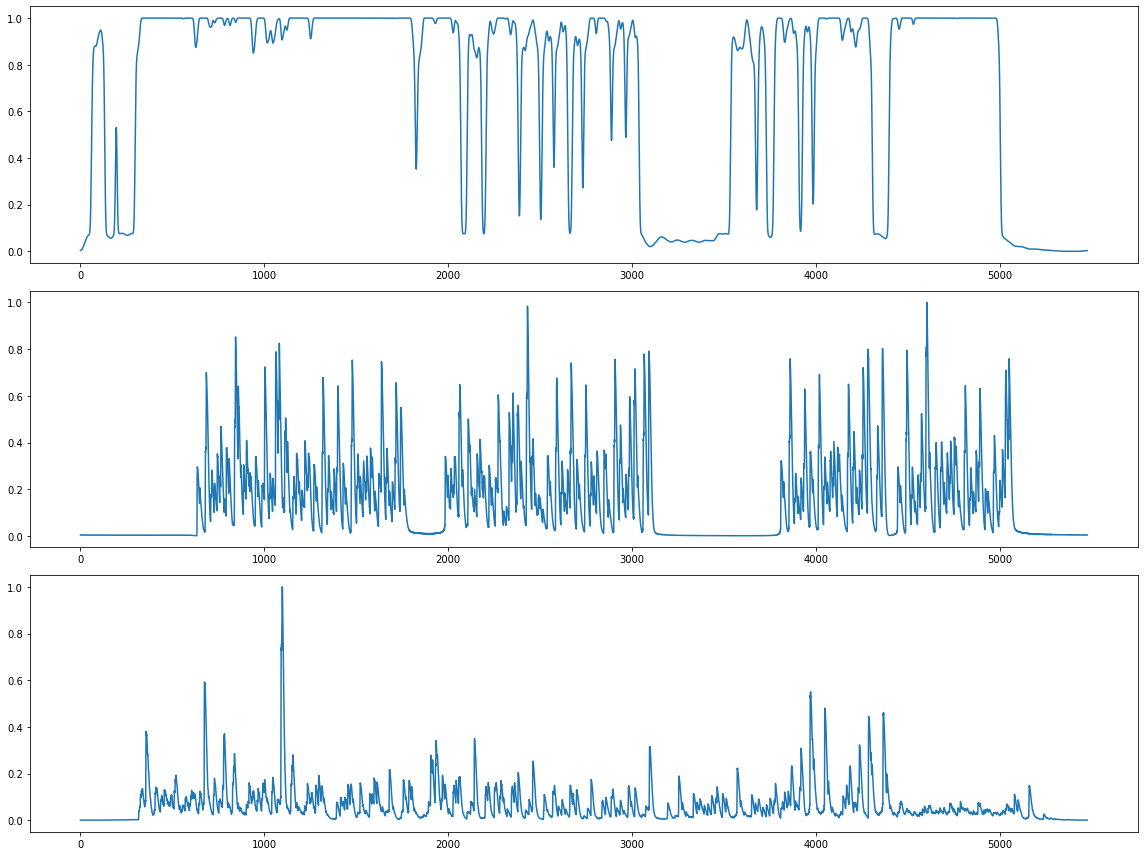


generating latents...
chroma:


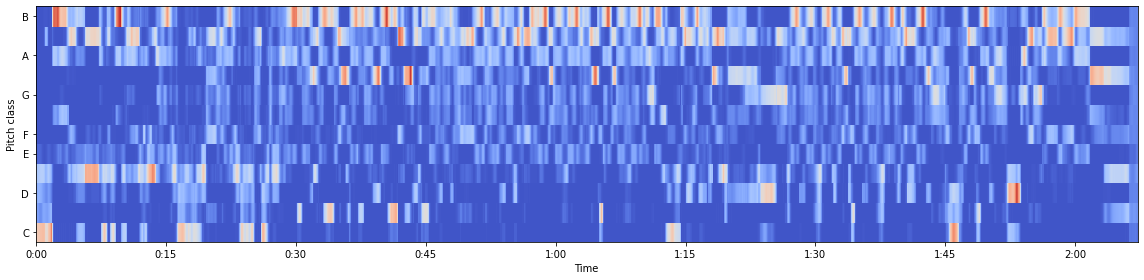

[5478, 18, 512] amplitude=0.19866928458213806

generating noise...
[5478, 1, 4, 8] amplitude=0.5000000596046448
[5478, 1, 8, 16] amplitude=0.5
[5478, 1, 8, 16] amplitude=0.5000000596046448
[5478, 1, 16, 32] amplitude=0.4999999701976776
[5478, 1, 16, 32] amplitude=0.5
[5478, 1, 32, 64] amplitude=0.5000000596046448
[5478, 1, 32, 64] amplitude=0.5
[5478, 1, 64, 128] amplitude=0.5000000596046448
[5478, 1, 64, 128] amplitude=0.5000000596046448
[5478, 1, 128, 256] amplitude=0.5
[5478, 1, 128, 256] amplitude=0.5

generating network bends...

preprocessing took 89.87s

rendering 5478 frames...


100%|███████████████████████████████████████| 5478/5478 [11:04<00:00,  8.24it/s]



total time taken: 12.76 minutes


In [ ]:
from generate_audiovisual import generate
# you want to set the batch size and ffmpeg_preset as large and as slow as your GPU can handle
# larger batches => faster, slower preset => smaller + better quality video files
generate(
  ckpt="network-snapshot-000384.pt",
  audio_file="Song 113.d.wav",
  output_dir="../",
  out_size=1920, # at the moment only 512x512, 1024x1024, 1920x1080 outputs are supported (out_size = 512, 1024, or 1920 respectively)
  # out_size=1920, # at the moment only 512x512, 1024x1024, 1920x1080 outputs are supported (out_size = 512, 1024, or 1920 respectively)
  G_res=1024,
  batch=2,  # 4, slow works CUDA out of memory errors => smaller batch (also try running the previous cell, to clear some GPU memory)
  ffmpeg_preset="medium",  # RAM crashes => faster preset (see https://trac.ffmpeg.org/wiki/Encode/H.264)
  fps=30,
  # duration=135, # remove this line for full video
  initialize=initialize,
  get_latents=get_latents,
  get_noise=get_noise,
  get_bends=get_bends, # if you're running a 1024px network you can uncomment this for 1920x1080 output
  # latent_file="my_latents.npy"
)

You can now upload a new audio file using the following cell and then render it by only executing the previous cell.

In [ ]:
from google.colab import files
uploaded = files.upload()
audio_file = list(uploaded.keys())[0]
print('User uploaded file "{name}" with length {length} bytes'.format(name=audio_file, length=len(uploaded[audio_file])))

Saving Song 113.d.wav to Song 113.d.wav
User uploaded file "Song 113.d.wav" with length 31752044 bytes


P.S.

To load seeds from NVIDIA's official stylegan repositories (or forks thereof):

In [ ]:
import numpy as np

seed1 = 728
nvlatent1 = np.random.RandomState(seed1).randn(1, 512) # shape = [1, 512]
latent1 = np.stack([nvlatent1]*18, axis=1) # shape = [1, 18, 512]

seed2 = 797
nvlatent2 = np.random.RandomState(seed2).randn(1, 512) # shape = [1, 512]
latent2 = np.stack([nvlatent2]*18, axis=1) # shape = [1, 18, 512]

seed3 = 731
nvlatent3 = np.random.RandomState(seed3).randn(1, 512) # shape = [1, 512]
latent3 = np.stack([nvlatent3]*18, axis=1) # shape = [1, 18, 512]

seed4 = 709
nvlatent4 = np.random.RandomState(seed4).randn(1, 512) # shape = [1, 512]
latent4 = np.stack([nvlatent4]*18, axis=1) # shape = [1, 18, 512]

seed12 = 736
nvlatent12 = np.random.RandomState(seed12).randn(1, 512) # shape = [1, 512]
latent12 = np.stack([nvlatent12]*18, axis=1) # shape = [1, 18, 512]

seed5 = 760
nvlatent5 = np.random.RandomState(seed5).randn(1, 512) # shape = [1, 512]
latent5 = np.stack([nvlatent5]*18, axis=1) # shape = [1, 18, 512]

seed6 = 716
nvlatent6 = np.random.RandomState(seed6).randn(1, 512) # shape = [1, 512]
latent6 = np.stack([nvlatent6]*18, axis=1) # shape = [1, 18, 512]

seed7 = 740
nvlatent7 = np.random.RandomState(seed7).randn(1, 512) # shape = [1, 512]
latent7 = np.stack([nvlatent7]*18, axis=1) # shape = [1, 18, 512]

seed8 = 710
nvlatent8 = np.random.RandomState(seed8).randn(1, 512) # shape = [1, 512]
latent8 = np.stack([nvlatent8]*18, axis=1) # shape = [1, 18, 512]

seed9 = 738
nvlatent9 = np.random.RandomState(seed9).randn(1, 512) # shape = [1, 512]
latent9 = np.stack([nvlatent9]*18, axis=1) # shape = [1, 18, 512]

seed10 = 719
nvlatent10 = np.random.RandomState(seed10).randn(1, 512) # shape = [1, 512]
latent10 = np.stack([nvlatent10]*18, axis=1) # shape = [1, 18, 512]

seed11 = 733
nvlatent11 = np.random.RandomState(seed11).randn(1, 512) # shape = [1, 512]
latent11 = np.stack([nvlatent11]*18, axis=1) # shape = [1, 18, 512]


latents = np.concatenate([latent1, latent2, latent3, latent4, latent12, latent5, latent6, latent7, latent8, latent9, latent10, latent11], axis=0) # shape = [12, 18, 512]

np.save("my_latents.npy", latents)

This assumes a default 1024x1024 network (18 layers) with a latent dimension of 512. You'll need to adjust some numbers above if your network has a different resolution or latent_dim.

Now `my_latents.npy` can be loaded to `generate()` as an argument `latent_file="my_latents.npy"`